In [1]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.lw.info

import rtmtools.rrtmg.lw.wrangle as rrtmgwrangle

import climatools.rrtmg.info as rrtmginfo
import climatools.clirad.info as cliradinfo

importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.lw.info)
importlib.reload(cliradinfo)

importlib.reload(rrtmgwrangle)

importlib.reload(rrtmginfo)
importlib.reload(cliradinfo)

<module 'climatools.clirad.info' from '/nuwa_cluster/home/jackyu/climatools/climatools/clirad/info.py'>

In [2]:
name_molecule = 'CO2' #r'$H_{2}O$'

In [3]:
#### Load CRD results

In [4]:
# Get lbl line-by-line results
pathout_crd = os.path.join('/nuwa_cluster/home/jackyu',
                           'radiation/crd/LW/examples', 
                           'lbl_H2008_CO2_cut25/OUTPUT_RADSUM')

pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom=pathout_crd, 
                                                cooling_rate=True, 
                                                signed_fluxes=True)

In [5]:
# H1996 cutoff = 10 cm-1
pathout_crd1 = os.path.join('/nuwa_cluster/home/jackyu',
                            'radiation/crd/LW/examples',
                            'lbl_H1996_CO2_cut10/OUTPUT_RADSUM')

pnl_crd1 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom=pathout_crd1, 
                                                 cooling_rate=True, 
                                                 signed_fluxes=True)

In [6]:
#### Load CLIRAD results

In [7]:
# Read OUTPUT_CLIRAD.dat
pathout_clirad = os.path.join('/nuwa_cluster/home/jackyu',
                              'radiation/clirad/LW/examples',
                              'mls75_CO2_H2012/OUTPUT_CLIRAD.dat')

pnl_clirad = cliradwrangle.\
             OUTPUT_CLIRAD_to_PandasPanel(readfrom=pathout_clirad,
                                          cooling_rate=True, 
                                          signed_fluxes=True)

In [8]:
pathout_clirad_96 = os.path.join('/nuwa_cluster/home/jackyu',
                                 'radiation/clirad/LW/examples',
                                 'mls75_CO2/OUTPUT_CLIRAD.dat')

pnl_clirad_96 = cliradwrangle.\
                OUTPUT_CLIRAD_to_PandasPanel(readfrom=pathout_clirad_96, 
                                             cooling_rate=True,
                                             signed_fluxes=True)

In [23]:
# prepare results Hitran 2012 updated version
def path_cliradlw_h2012():
    return '../clirad/LW/examples/mls75_CO2_H2012/CLIRAD_IR_output.dat'


def get_rateT(df, ratename = 'cooling rates'):
    return pd.DataFrame({'pressure': .5 * (df['p'].values[1:] 
                                           + df['p'].values[: -1]),
                        ratename: df[ratename].values[1:]})


#df = cliradwrangle.output_txtfile_to_DataFrame(path_cliradlw_h2012())

#rateT_clirad2012 = get_rateT(df, ratename = 'cooling rates')

In [9]:
#### Load LBLRTM results

In [10]:
# Get AER line-by-line results
pathout_lblrtm = os.path.join('/nuwa_cluster/home/jackyu',
                              'line_by_line/aerlbl_v12.2_package',
                              'runs/LW/run_mls75pro_CO2/OUTPUT_RADSUM')

pnl_lblrtm = aerutils.\
             OUTPUT_RADSUM_to_pandasPanel(readfrom=pathout_lblrtm, 
                                          signed_fluxes=True, 
                                          cooling_rate=True)

In [11]:
#### Load RRTMG results

In [12]:
pathout_rrtmg = os.path.join('/nuwa_cluster/home/jackyu',
                             'radiation/rrtmg/LW/examples',
                             'mls70_CO2/OUTPUT_RRTM')

pnl_rrtmg = rrtmgwrangle.\
            OUTPUT_RRTM_to_pandasPanel(readfrom=pathout_rrtmg,
                                       signed_fluxes=True,
                                       cooling_rate = True)

# Whole spectral range

In [13]:
def results_all_wavenumbers(infos_wavenumber=None,
                            infos_spectralband=None,
                            name_molecule='name of molecule'):
    
    # align the spectral dimensions
    if infos_wavenumber:
        (names_wavenumber, 
         colours_wavenumber, 
         linestyles_wavenumber, 
         pnls_wavenumber) = map(list, zip(*infos_wavenumber))
    
        dfs_wavenumber = [aeranalyse\
                          .sum_OUTPUT_RADSUM_over_wbands(pnl, 
                                                         V1=0, V2=3000)
                          for pnl in pnls_wavenumber]
    else:
        (names_wavenumber, 
         colours_wavenumber, 
         linestyles_wavenumber, 
         dfs_wavenumber) = [], [] , [], []
    
    if infos_spectralband:
        (names_spectralband, 
         colours_spectralband, 
         linestyles_spectralband, 
         pnls_spectralband) = map(list, zip(*infos_spectralband))
    
        dfs_spectralband = [cliradanalyse\
                            .sum_OUTPUT_CLIRAD_over_wbands(pnl, 
                                                wbands=range(1, 11))
                            for pnl in pnls_spectralband]
    else:
        (names_spectralband, 
         colours_spectralband, 
         linestyles_spectralband, 
         dfs_spectralband) = [], [], [], []

    # sort into data and display properties
    dfs = dfs_wavenumber + dfs_spectralband
    names = names_wavenumber + names_spectralband
    colours = colours_wavenumber + colours_spectralband
    linestyles = linestyles_wavenumber + linestyles_spectralband    
    
    # make summary table for differences fluxes and heating rate
    atm_levels = [70, 30, 0]
    dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
    df_diffs = viz.tabulate_difference(dfs=dfs_atm_levels, 
                                       names=names,
                                       return_original=True)
    
    # write summary table to excel file
    name_excelfile = 'longwave_mls_{}_total.xlsx'.format(name_molecule)
    with pd.ExcelWriter(name_excelfile) as writer:
        df_diffs.to_excel(writer, sheet_name='total')    
        
    # display summary table in notebook
    for name_diff in df_diffs.index.levels[0]:
        df_print = df_diffs.loc[(name_diff, slice(None)), :]
        df_print.index = df_print.index.droplevel(0)
        print(name_diff)
        print(df_print)
        print()
        
    viz.plot_pres_vs_hrcr(dfs=dfs,
                          names=names,
                          linestyles=linestyles, 
                          colours=colours,
                          title=('Total cooling rate. {}'\
                                 .format(name_molecule)),
                          cooling_rate=True,
                          xlim_linear=None,
                          xlim_log=None)
    
    display.display(plt.gcf()); plt.close()    

CRD
       pressure     flux_up  flux_down    net_flux  cooling_rate
70     0.002417 -383.273276   0.000000 -383.273276      0.000000
30   299.800000 -389.763984  21.277476 -368.486508      0.155939
0   1013.000000 -423.662018  77.656605 -346.005414      0.364312

LBLRTM
     pressure     flux_up  flux_down    net_flux  cooling_rate
70     0.0024 -383.100650   0.000000 -383.100650      0.000000
30   299.8000 -389.784564  21.088600 -368.695964      0.146416
0   1013.0000 -423.532488  77.113869 -346.418619      0.352086

RRTMG
      pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -382.5392     0.0000 -382.5392       0.00000
30   299.70000 -389.3473    21.3458 -368.0015       0.14629
0   1013.00000 -423.5988    78.3065 -345.2923       0.39335

CLIRAD
       pressure     flux_up  flux_down    net_flux  cooling_rate
70     0.002417 -385.167538   0.012388 -385.155150     19.815700
30   299.800000 -391.205408  20.990990 -370.214418      0.153921
0   1013.000000 -423.78618

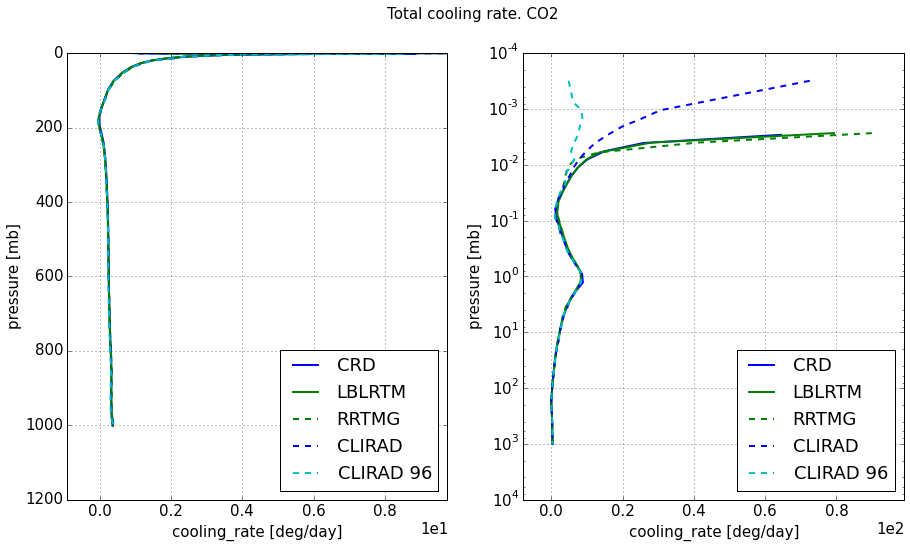

In [14]:
results_all_wavenumbers(
    infos_wavenumber=[('CRD', 'b', '-', pnl_crd),
                      ('LBLRTM', 'g', '-', pnl_lblrtm),
                      ('RRTMG', 'g', '--', pnl_rrtmg)],
    infos_spectralband=[('CLIRAD', 'b', '--', pnl_clirad),
                        ('CLIRAD 96', 'c', '--', pnl_clirad_96)],
    name_molecule=name_molecule)

In [15]:
html_download = ('<a href="./longwave_mls_{name_molecule}_total.xlsx"'
                 'download>longwave_mls_{name_molecule}_total.xlsx</a>')

display.HTML(html_download.format(name_molecule=name_molecule))

# In RRTMG's wavenumber bands

In [16]:
def results_by_rrtmg_bands(infos_rrtmg=None,
                           infos_lbl=None,
                           name_molecule='name of molecule'):
    
    wbands = list(itertools.chain.from_iterable(
        rrtmginfo.wavenumber_bands(region='lw').values()))
    
   
    # align spectral dimensions
    if infos_lbl:
        (names_lbl, 
         colours_lbl, 
         linestyles_lbl, 
         pnls_lbl) = map(list, zip(*infos_lbl))
        
        pnls_lbl = [aeranalyse
                    .lines2bands(pnl_lbl, wbands=wbands)
                    for pnl_lbl in pnls_lbl]
    else:
        (names_lbl, 
         colours_lbl, 
         linestyles_lbl, 
         pnls_lbl) = ([], [], [], [])
        
    if infos_rrtmg:
        (names_rrtmg,
         colours_rrtmg,
         linestyles_rrtmg,
         pnls_rrtmg) = map(list, zip(*infos_rrtmg))
    else:
        (names_rrtmg, 
         colours_rrtmg, 
         linestyles_rrtmg,
         pnls_rrtmg) = ([], [], [], [])

    # sort into data panels and display properties
    names = names_rrtmg + names_lbl
    colours = colours_rrtmg + colours_lbl
    linestyles = linestyles_rrtmg + linestyles_lbl
    pnls = pnls_rrtmg + pnls_lbl
        
    # Make summary table for differences fluxes and heating rate
    # at these atmosphere levels
    atm_levels = [70, 30, 0]
    
    # Open excel file to write the summary tables into
    name_excelfile = ('longwave_mls_{}_by_rrtmg_bands.xlsx'\
                      .format(name_molecule))
    with pd.ExcelWriter(name_excelfile) as writer:
        
        for i, (v1, v2) in enumerate(wbands):
            name_band = ('{}. {} ~ {} cm-1'
                         .format(i + 1, v1, v2))
            dfs = [pnl[(v1, v2)] for pnl in pnls]
            
            # Make summary table for differences fluxes and heating rate
            dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
            df_diffs = viz.tabulate_difference(dfs=dfs_atm_levels, 
                                               names=names,
                                               return_original=True)
            
            # write summary table to excel file
            df_diffs.to_excel(writer, sheet_name=name_band)
        
            # display summary table in notebook
            print('RRTMG-LW spectral band ' + name_band + '\n')
            for name_diff in df_diffs.index.levels[0]:
                df_print = df_diffs.loc[(name_diff, slice(None)), :]
                df_print.index = df_print.index.droplevel(0)
                print(name_diff)
                print(df_print)
                print()    
        
            # plot heating/cooling rate
            viz.plot_pres_vs_hrcr(dfs=dfs,
                                  names=names,
                                  linestyles=linestyles, 
                                  colours=colours,
                                  title=('Cooling rate {} {} ~ {} cm-1'\
                                         .format(name_molecule, 
                                                 *(v1, v2))),
                                  cooling_rate=True,
                                  xlim_linear=None,
                                  xlim_log=None)
    
            display.display(plt.gcf()); plt.close()
            print()
            print('------------------------------------'
                  '------------------------------------')
            print()
    

Flux tables and cooling rates in RRTMG spectral bands


RRTMG-LW spectral band 1. 10.0 ~ 350.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -54.5825          0  -54.5825            -0
30   299.70000 -54.5825          0  -54.5825            -0
0   1013.00000 -54.5825          0  -54.5825            -0

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -54.573788  0.000000e+00 -54.573788  0.000000e+00
30   299.800000 -54.573788  2.932884e-07 -54.573787  1.572515e-09
0   1013.000000 -54.573788  6.174024e-07 -54.573787  4.363773e-09

LBLRTM
     pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.0024 -54.662493  0.000000e+00 -54.662493  0.000000e+00
30   299.8000 -54.662493  1.133169e-08 -54.662493  2.601352e-10
0   1013.0000 -54.581667  6.027854e-08 -54.581667  2.868963e-02

RRTMG - CRD
    pressure   flux_up     flux_down  net_flux  cooling_rate
70  0.000003 -0.008712  0.000000e+00 -0.008712 -0.

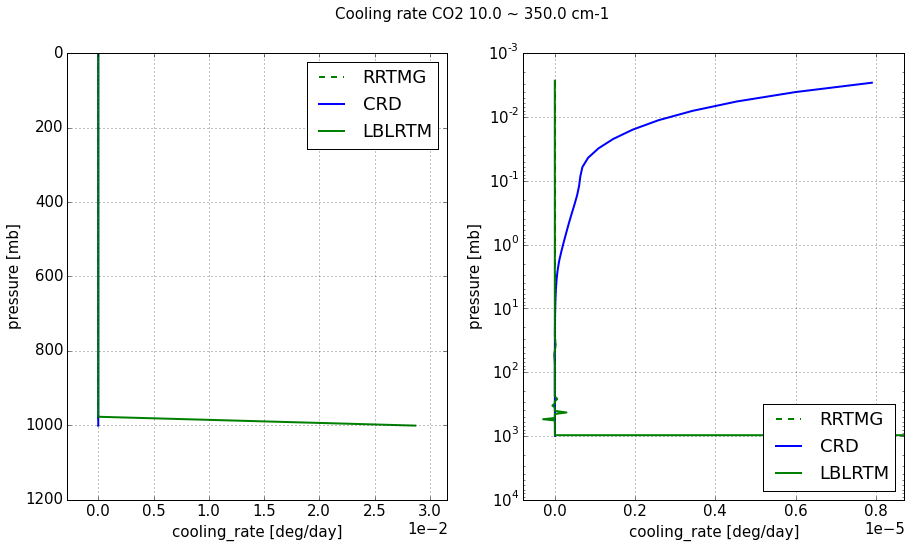


------------------------------------------------------------------------

RRTMG-LW spectral band 2. 350.0 ~ 500.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -60.9174          0  -60.9174            -0
30   299.70000 -60.9174          0  -60.9174            -0
0   1013.00000 -60.9174          0  -60.9174            -0

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -60.916037   0.000000 -60.916037  0.000000e+00
30   299.800000 -60.916124   0.000088 -60.916036  6.718444e-07
0   1013.000000 -60.916638   0.004098 -60.912539  9.973436e-05

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.928294   0.000000 -60.928294  0.000000e+00
30   299.8000 -60.928382   0.000088 -60.928294  6.721261e-07
0   1013.0000 -60.917465   0.004240 -60.913225  4.166610e-03

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.001363   0.000000 -0.001363 -0.000000e+00

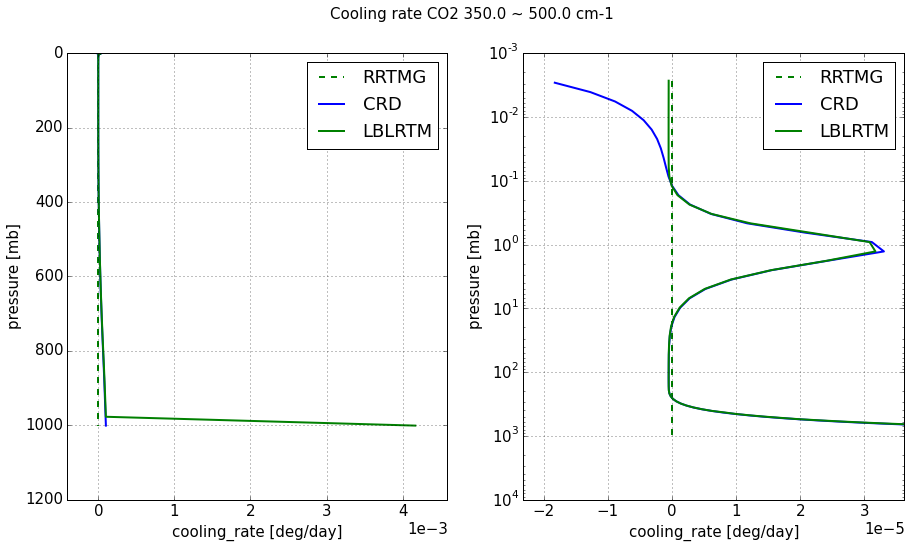


------------------------------------------------------------------------

RRTMG-LW spectral band 3. 500.0 ~ 630.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -50.5085     0.0000  -50.5085      -0.00000
30   299.70000 -52.2550     3.7925  -48.4625       0.06232
0   1013.00000 -58.6466    20.2704  -38.3762       0.14667

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -50.013538   0.000000 -50.013538      0.000000
30   299.800000 -51.778173   3.688252 -48.089921      0.060808
0   1013.000000 -58.652387  20.651726 -38.000661      0.146138

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -50.089815   0.000000 -50.089815      0.000000
30   299.8000 -51.879163   3.664142 -48.215022      0.057074
0   1013.0000 -58.646623  20.398981 -38.247643      0.147339

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.494962   0.000000 -0.494962     -0.000000

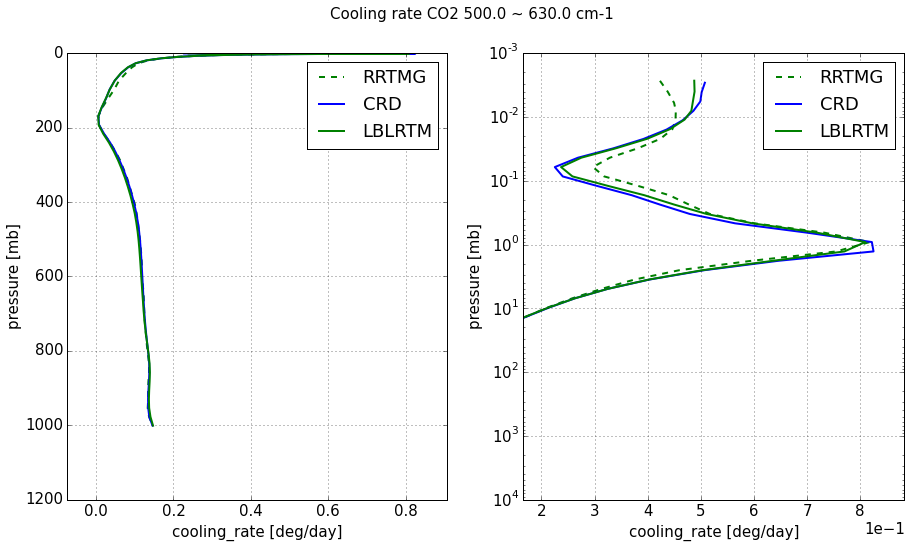


------------------------------------------------------------------------

RRTMG-LW spectral band 4. 630.0 ~ 700.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -11.9206     0.0000  -11.9206      -0.00000
30   299.70000 -14.5137    13.5131   -1.0006       0.04246
0   1013.00000 -30.8956    30.8437   -0.0519       0.01923

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -12.094168   0.000000 -12.094168      0.000000
30   299.800000 -14.490814  13.462047  -1.028767      0.044383
0   1013.000000 -30.901144  30.860796  -0.040348      0.012921

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -12.024680   0.000000 -12.024680      0.000000
30   299.8000 -14.566414  13.371418  -1.194996      0.042751
0   1013.0000 -30.895458  30.823546  -0.071911      0.015444

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.173568   0.000000  0.173568     -0.000000

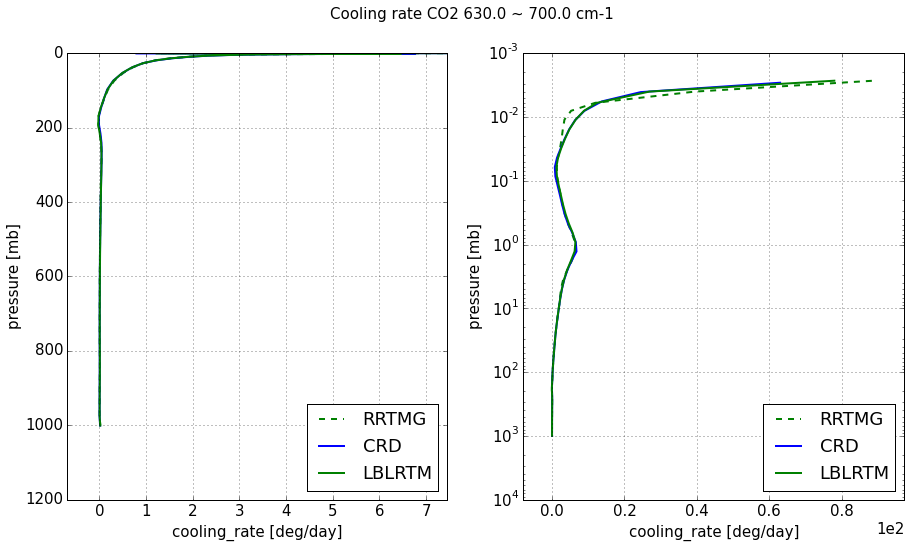


------------------------------------------------------------------------

RRTMG-LW spectral band 5. 700.0 ~ 820.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -37.0499     0.0000  -37.0499      -0.00000
30   299.70000 -39.2274     3.9085  -35.3189       0.05061
0   1013.00000 -48.8871    23.7295  -25.1576       0.16952

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -37.572063   0.000000 -37.572063      0.000000
30   299.800000 -39.674031   4.024062 -35.649969      0.057152
0   1013.000000 -48.899846  23.285903 -25.613942      0.155854

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -37.739301   0.000000 -37.739301      0.000000
30   299.8000 -39.854528   3.940537 -35.913991      0.053080
0   1013.0000 -48.886744  22.864324 -26.022420      0.154689

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.522163   0.000000  0.522163     -0.000000

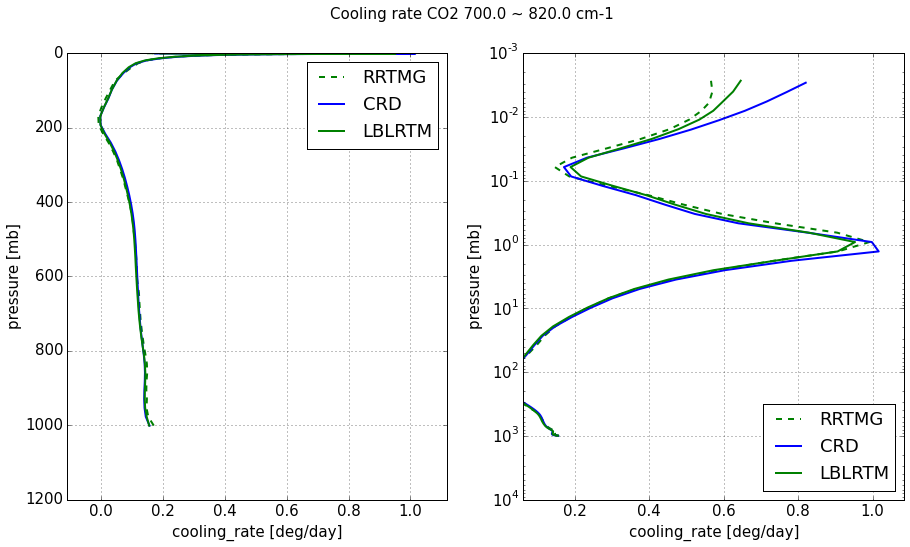


------------------------------------------------------------------------

RRTMG-LW spectral band 6. 820.0 ~ 980.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -53.6469     0.0000  -53.6469      -0.00000
30   299.70000 -53.7136     0.0234  -53.6902      -0.00157
0   1013.00000 -53.9607     0.9552  -53.0055       0.02181

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -53.700735   0.000000 -53.700735      0.000000
30   299.800000 -53.754410   0.023077 -53.731332     -0.001126
0   1013.000000 -53.981634   0.814348 -53.167285      0.017664

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -53.666749   0.000000 -53.666749      0.000000
30   299.8000 -53.719835   0.022087 -53.697748     -0.001120
0   1013.0000 -53.960338   0.782696 -53.177642      0.008939

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.053835   0.000000  0.053835     -0.000000

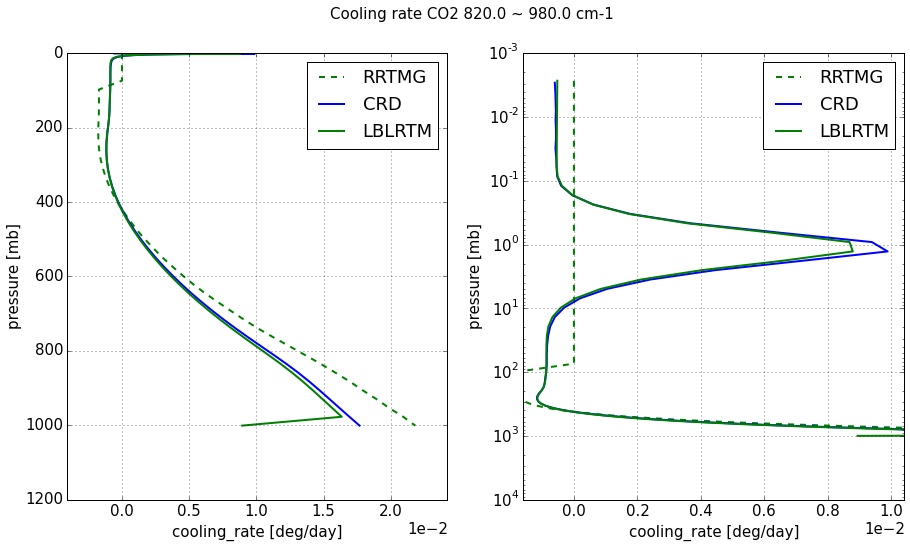


------------------------------------------------------------------------

RRTMG-LW spectral band 7. 980.0 ~ 1080.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -26.2384     0.0000  -26.2384      -0.00000
30   299.70000 -26.3484     0.0353  -26.3131      -0.00218
0   1013.00000 -26.6401     0.9389  -25.7012       0.02001

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -26.304439   0.000000 -26.304439      0.000000
30   299.800000 -26.370653   0.025184 -26.345469     -0.001606
0   1013.000000 -26.654056   0.880085 -25.773972      0.018657

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -26.290021   0.000000 -26.290021      0.000000
30   299.8000 -26.355982   0.024205 -26.331776     -0.001603
0   1013.0000 -26.640246   0.850691 -25.789554      0.014198

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.066039   0.000000  0.066039     -0.00000

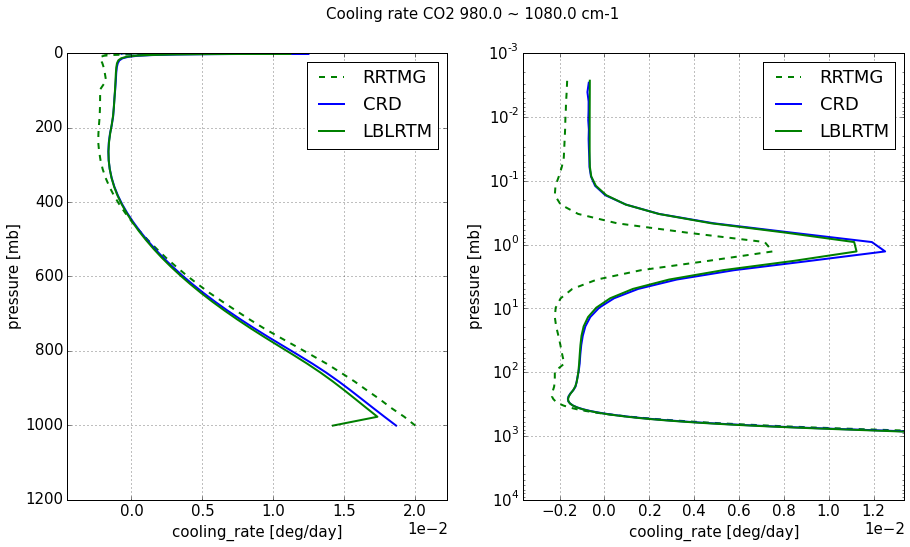


------------------------------------------------------------------------

RRTMG-LW spectral band 8. 1080.0 ~ 1180.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -21.4454     0.0000  -21.4454      -0.00000
30   299.70000 -21.4641     0.0050  -21.4591      -0.00048
0   1013.00000 -21.5225     0.1826  -21.3399       0.00441

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -21.465427   0.000000 -21.465427      0.000000
30   299.800000 -21.476758   0.004027 -21.472731     -0.000305
0   1013.000000 -21.535940   0.192343 -21.343597      0.004442

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -21.448097   0.000000 -21.448097      0.000000
30   299.8000 -21.459109   0.003766 -21.455343     -0.000295
0   1013.0000 -21.522739   0.178986 -21.343752      0.001087

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.020027   0.000000  0.020027     -0.0000

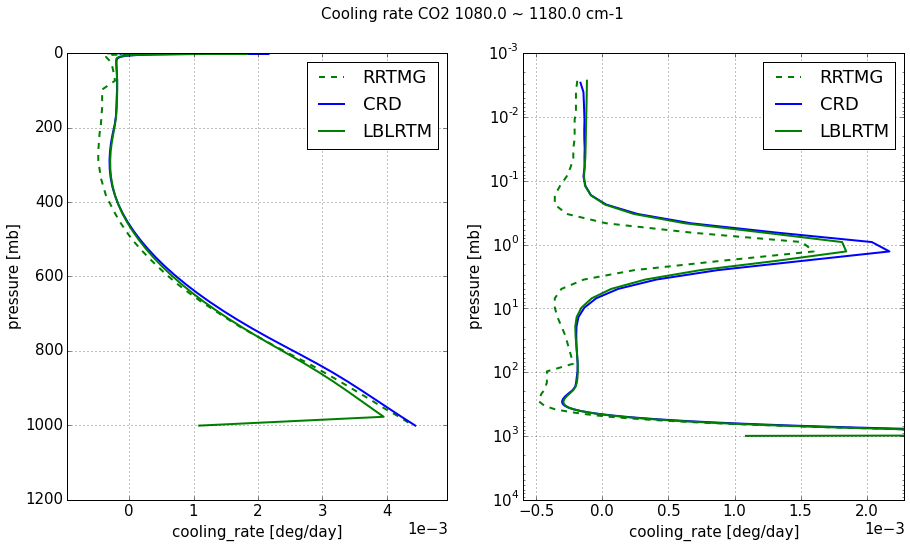


------------------------------------------------------------------------

RRTMG-LW spectral band 9. 1180.0 ~ 1390.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -31.2994          0  -31.2994            -0
30   299.70000 -31.2994          0  -31.2994            -0
0   1013.00000 -31.2994          0  -31.2994            -0

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -31.247130   0.000000 -31.247130      0.000000
30   299.800000 -31.284525   0.006237 -31.278288     -0.000731
0   1013.000000 -31.323236   0.073322 -31.249914      0.001210

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -31.213357   0.000000 -31.213357      0.000000
30   299.8000 -31.250103   0.006031 -31.244072     -0.000709
0   1013.0000 -31.299603   0.070968 -31.228635     -0.003131

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.052270   0.000000 -0.052270     -0.0000

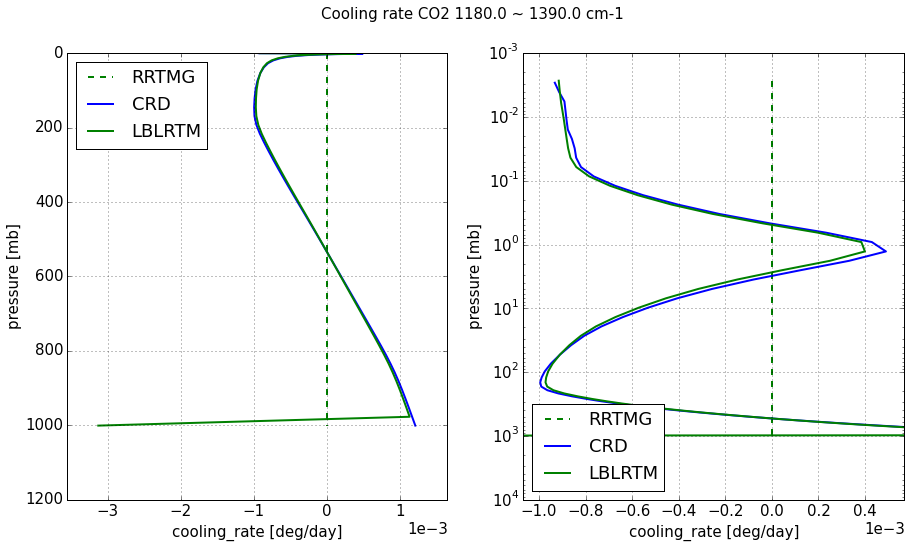


------------------------------------------------------------------------

RRTMG-LW spectral band 10. 1390.0 ~ 1480.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -8.8986          0   -8.8986            -0
30   299.70000  -8.8986          0   -8.8986            -0
0   1013.00000  -8.8986          0   -8.8986            -0

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -8.903635   0.000000 -8.903635      0.000000
30   299.800000 -8.904803   0.000173 -8.904630     -0.000027
0   1013.000000 -8.906562   0.003409 -8.903153      0.000067

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -8.891755   0.000000 -8.891755      0.000000
30   299.8000 -8.892931   0.000173 -8.892758     -0.000027
0   1013.0000 -8.898490   0.003467 -8.895022     -0.001273

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.005035   0.000000  0.005035     -0.000000
30 -0.100000

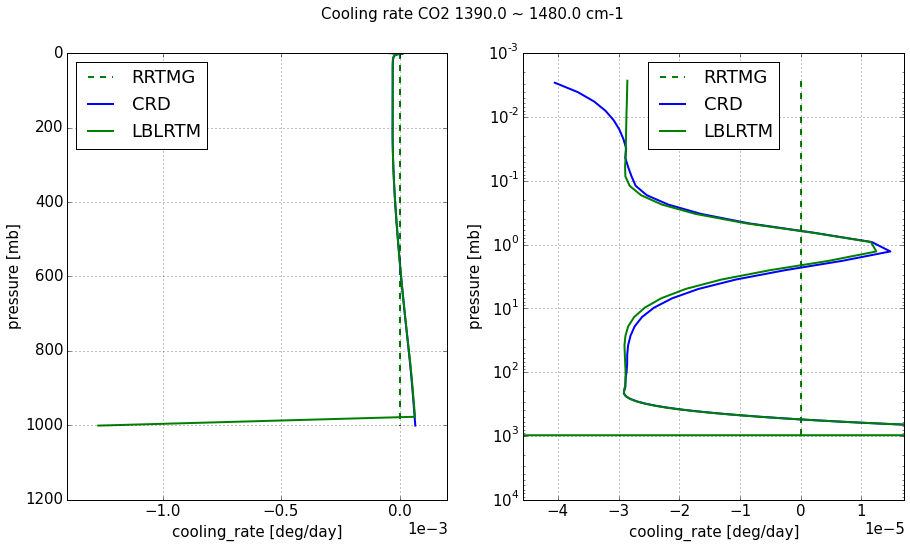


------------------------------------------------------------------------

RRTMG-LW spectral band 11. 1480.0 ~ 1800.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -17.8828          0  -17.8828            -0
30   299.70000 -17.8828          0  -17.8828            -0
0   1013.00000 -17.8828          0  -17.8828            -0

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -17.902258  0.000000e+00 -17.902258  0.000000e+00
30   299.800000 -17.902258  2.293236e-08 -17.902258 -9.065695e-10
0   1013.000000 -17.902258  9.652420e-08 -17.902258  1.635737e-09

LBLRTM
     pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.0024 -17.873994  0.000000e+00 -17.873994  0.000000e+00
30   299.8000 -17.873995  8.729626e-08 -17.873995 -2.659371e-08
0   1013.0000 -17.882889  1.134969e-05 -17.882877 -3.154926e-03

RRTMG - CRD
    pressure   flux_up     flux_down  net_flux  cooling_rate
70  0.000003  0.019458  0.0

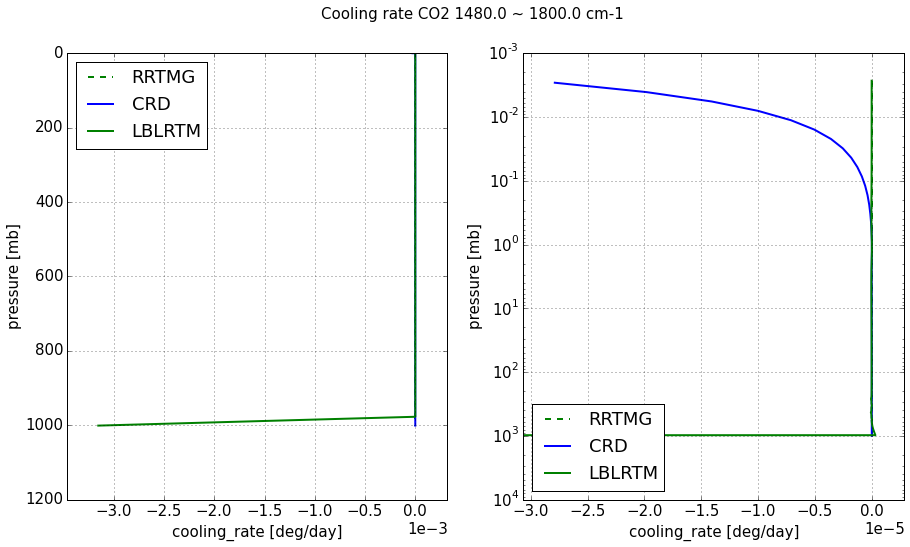


------------------------------------------------------------------------

RRTMG-LW spectral band 12. 1800.0 ~ 2080.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -5.7512     0.0000   -5.7512      -0.00000
30   299.70000  -5.7979     0.0060   -5.7919      -0.00187
0   1013.00000  -5.9578     0.2047   -5.7531       0.00384

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -5.748949   0.000000 -5.748949      0.000000
30   299.800000 -5.798119   0.006325 -5.791794     -0.001787
0   1013.000000 -5.965987   0.211806 -5.754180      0.004055

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -5.683672   0.000000 -5.683672      0.000000
30   299.8000 -5.733237   0.006116 -5.727120     -0.001784
0   1013.0000 -5.957771   0.203226 -5.754545     -0.018190

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.002251   0.000000 -0.002251     -0.000000
30 -0.100000

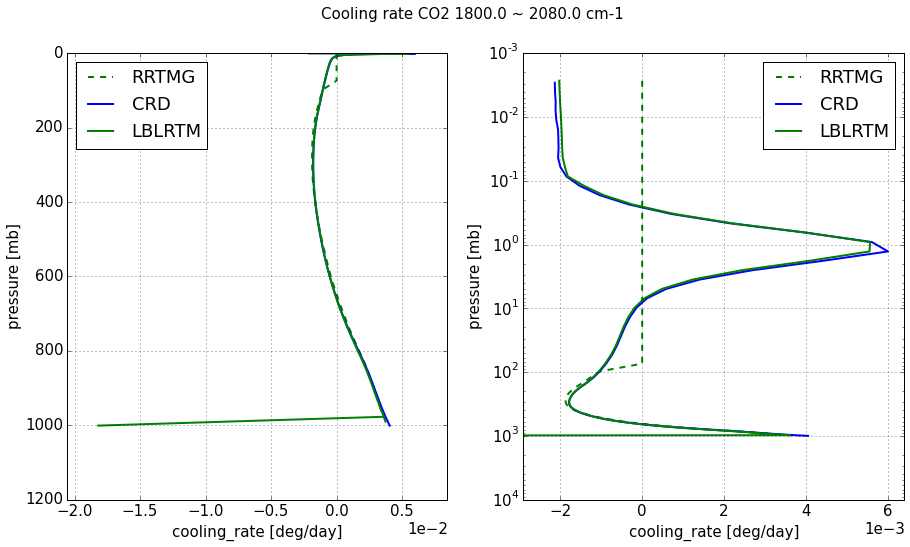


------------------------------------------------------------------------

RRTMG-LW spectral band 13. 2080.0 ~ 2250.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -1.3537     0.0000   -1.3537      -0.00000
30   299.70000  -1.4036     0.0070   -1.3966      -0.00192
0   1013.00000  -1.6390     0.2811   -1.3579       0.00457

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -1.590261   0.000000 -1.590261      0.000000
30   299.800000 -1.602115   0.000924 -1.601191     -0.000437
0   1013.000000 -1.641655   0.053801 -1.587854      0.001306

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -1.474235   0.000000 -1.474235      0.000000
30   299.8000 -1.496126   0.003815 -1.492312     -0.000836
0   1013.0000 -1.639014   0.183644 -1.455370      0.002800

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.236561   0.000000  0.236561     -0.000000
30 -0.100000

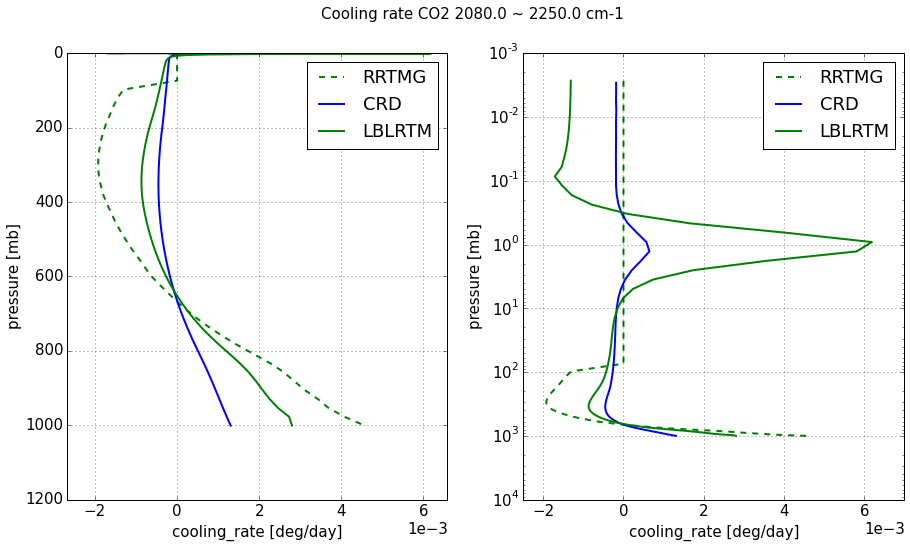


------------------------------------------------------------------------

RRTMG-LW spectral band 14. 2250.0 ~ 2380.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.0762     0.0000   -0.0762      -0.00000
30   299.70000  -0.0517     0.0513   -0.0004      -0.00001
0   1013.00000  -0.7316     0.7314   -0.0002       0.00008

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.236160   0.000000 -0.236160      0.000000
30   299.800000 -0.227483   0.034871 -0.192612     -0.000209
0   1013.000000 -0.732844   0.549390 -0.183454      0.001169

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.060062   0.000000 -0.060062      0.000000
30   299.8000 -0.061773   0.045019 -0.016754     -0.000339
0   1013.0000 -0.731556   0.724662 -0.006894      0.001244

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.159960   0.000000  0.159960     -0.000000
30 -0.100000

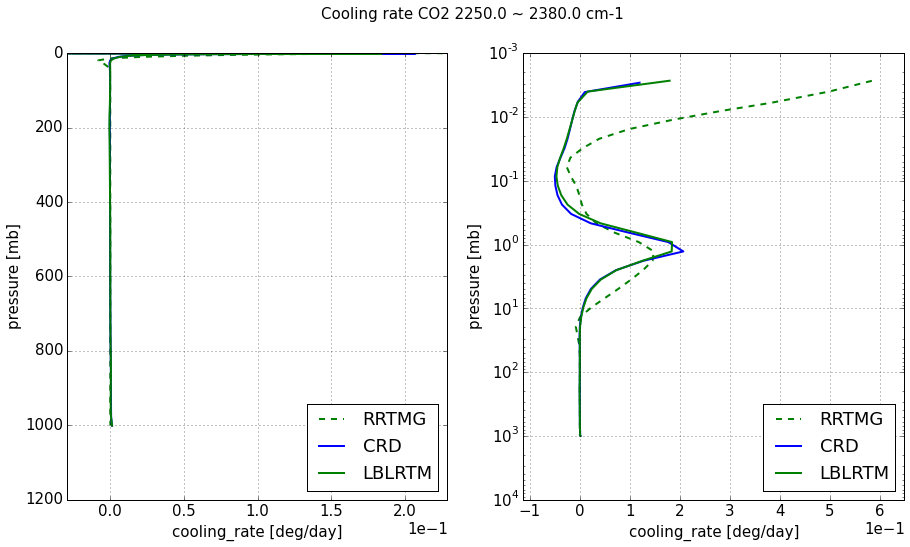


------------------------------------------------------------------------

RRTMG-LW spectral band 15. 2380.0 ~ 2600.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.4964     0.0000   -0.4964      -0.00000
30   299.70000  -0.5199     0.0037   -0.5162      -0.00107
0   1013.00000  -0.6658     0.1690   -0.4968       0.00321

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.598168   0.000000 -0.598168      0.000000
30   299.800000 -0.603234   0.002204 -0.601029     -0.000171
0   1013.000000 -0.667119   0.075381 -0.591739      0.000725

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.649414   0.000000 -0.649414      0.000000
30   299.8000 -0.645613   0.001198 -0.644415      0.000228
0   1013.0000 -0.665840   0.024235 -0.641604     -0.000431

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.101768   0.000000  0.101768     -0.000000
30 -0.100000

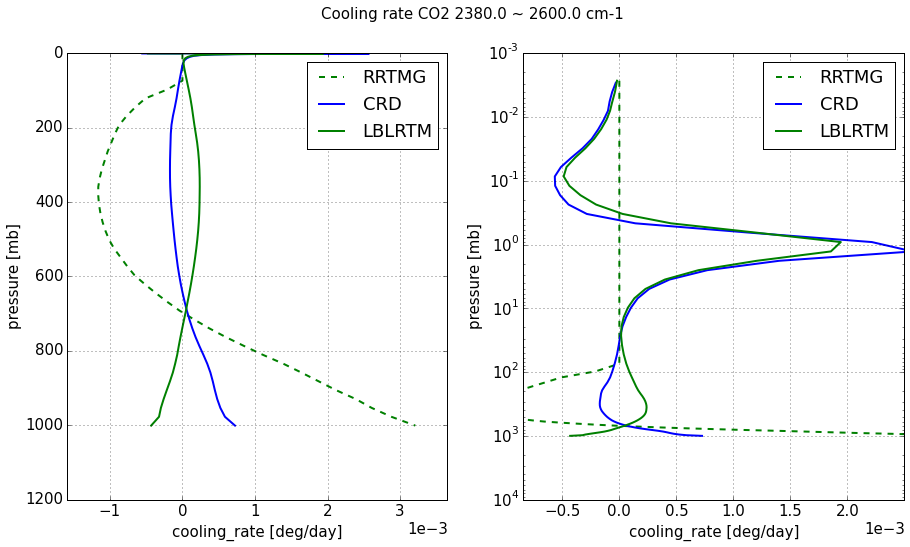


------------------------------------------------------------------------

RRTMG-LW spectral band 16. 2600.0 ~ 3250.0 cm-1

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.4713          0   -0.4713            -0
30   299.70000  -0.4713          0   -0.4713            -0
0   1013.00000  -0.4713          0   -0.4713            -0

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.404025   0.000000 -0.404025      0.000000
30   299.800000 -0.404201   0.000004 -0.404197     -0.000005
0   1013.000000 -0.404431   0.000195 -0.404236      0.000005

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.402034   0.000000 -0.402034      0.000000
30   299.8000 -0.402204   0.000004 -0.402201     -0.000005
0   1013.0000 -0.403547   0.000191 -0.403356     -0.000393

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.067275   0.000000 -0.067275     -0.000000
30 -0.100000

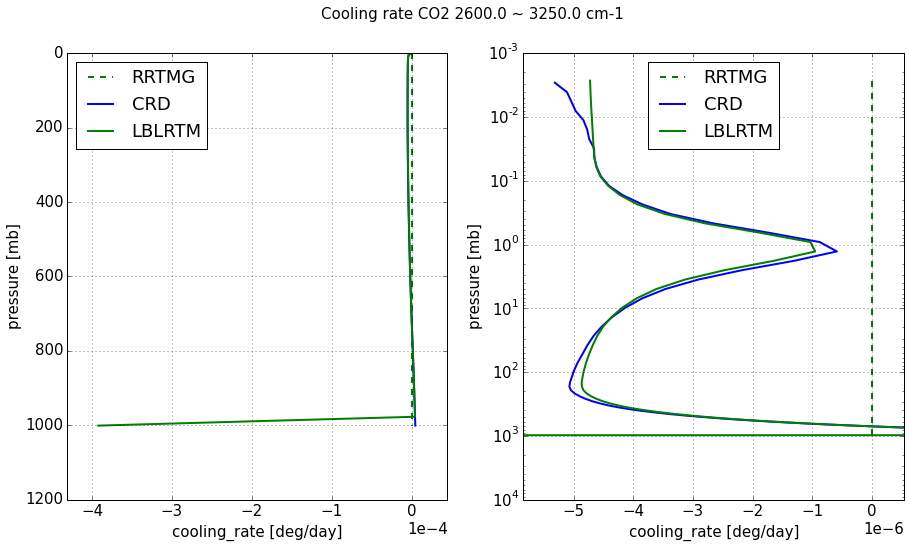


------------------------------------------------------------------------



In [17]:
print('Flux tables and cooling rates in RRTMG spectral bands')
print()
print()

results_by_rrtmg_bands(infos_rrtmg=[('RRTMG', 'g', '--', pnl_rrtmg)],
                       infos_lbl=[('CRD', 'b', '-', pnl_crd), 
                                  ('LBLRTM', 'g', '-', pnl_lblrtm)],
                       name_molecule=name_molecule)

In [18]:
html_download = ('<a href="./longwave_mls_{name_molecule}'
                 '_by_rrtmg_bands.xlsx"'
                 'download>longwave_mls_{name_molecule}'
                 '_by_rrtmg_bands.xlsx</a>')

display.HTML(html_download.format(name_molecule=name_molecule))

# In CLIRAD's wavenumber bands

In [19]:
def results_by_cliard_bands(infos_clirad=None,
                            infos_lbl=None,
                            name_molecule='name of molecule'):
        
    wbands = cliradinfo.wavenumber_bands(region='lw')
    
    # align spectral dimensions
    if infos_lbl:
        (names_lbl, 
         colours_lbl, 
         linestyles_lbl, 
         pnls_lbl) = map(list, zip(*infos_lbl))
        
        pnls_lbl = [rtmtools.clirad.sw.analyse\
                    .lines2bands(pnl_lbl, wbands=wbands)
                    for pnl_lbl in pnls_lbl]
    else:
        (names_lbl, 
         colours_lbl, 
         linestyles_lbl, 
         pnls_lbl) = ([], [], [], [])
        
    if infos_clirad:
        (names_clirad,
         colours_clirad,
         linestyles_clirad,
         pnls_clirad) = map(list, zip(*infos_clirad))
    else:
        (names_clirad, 
         colours_clirad, 
         linestyles_clirad,
         pnls_clirad) = ([], [], [], [])

    # sort into data panels and display properties
    names = names_clirad + names_lbl
    colours = colours_clirad + colours_lbl
    linestyles = linestyles_clirad + linestyles_lbl
    pnls = pnls_clirad + pnls_lbl
        
    # Make summary table for differences fluxes and heating rate
    # at these atmosphere levels
    atm_levels = [70, 30, 0]
    
    # Open excel file to write the summary tables into
    name_excelfile = ('longwave_mls_{}_by_clirad_bands.xlsx'\
                      .format(name_molecule))
    with pd.ExcelWriter(name_excelfile) as writer:
        
        for band in wbands.keys():
            name_band = ' '.join(['{} ~ {}'.format(v1, v2) 
                                  for v1, v2 in wbands[band]]) + ' cm-1'
            
            name_band = '{}. '.format(band) + name_band
            
            dfs = [pnl[band] for pnl in pnls]
            
            # Make summary table for differences fluxes and heating rate
            dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
            df_diffs = viz.tabulate_difference(dfs=dfs_atm_levels, 
                                               names=names,
                                               return_original=True)
            
            # write summary table to excel file
            df_diffs.to_excel(writer, sheet_name=name_band)
        
            # display summary table in notebook
            print('CLIRAD-LW spectral band ' + name_band + '\n')
            for name_diff in df_diffs.index.levels[0]:
                df_print = df_diffs.loc[(name_diff, slice(None)), :]
                df_print.index = df_print.index.droplevel(0)
                print(name_diff)
                print(df_print)
                print()    
        
            # plot heating/cooling rate
            viz.plot_pres_vs_hrcr(dfs=dfs,
                                  names=names,
                                  linestyles=linestyles, 
                                  colours=colours,
                                  title=('Cooling rate {} {}'\
                                         .format(name_molecule, 
                                                 name_band)),
                                  cooling_rate=True,
                                  xlim_linear=None,
                                  xlim_log=None)
    
            display.display(plt.gcf()); plt.close()
            print()
            print('------------------------------------'
                  '------------------------------------')
            print()
    

Flux tables and cooling rates in CLIRAD spectral bands


CLIRAD-LW spectral band 1. 0 ~ 340 cm-1

CLIRAD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -51.09212   0.000003 -51.092117 -5.771265e-07
30   299.800000 -51.09212   0.000003 -51.092117  2.273129e-09
0   1013.000000 -51.09213   0.000005 -51.092125  4.439772e-09

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -51.09304  0.000000e+00 -51.093040  0.000000e+00
30   299.800000 -51.09304  2.770028e-07 -51.093040  1.518605e-09
0   1013.000000 -51.09304  5.836491e-07 -51.093039  4.121978e-09

LBLRTM
     pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.0024 -51.180269  0.000000e+00 -51.180269  0.000000e+00
30   299.8000 -51.180269  1.139635e-08 -51.180269  2.614913e-10
0   1013.0000 -51.100657  5.105129e-08 -51.100657  2.825879e-02

CLIRAD - CRD
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0  0.00092   0.000003  0.000923 -5.7

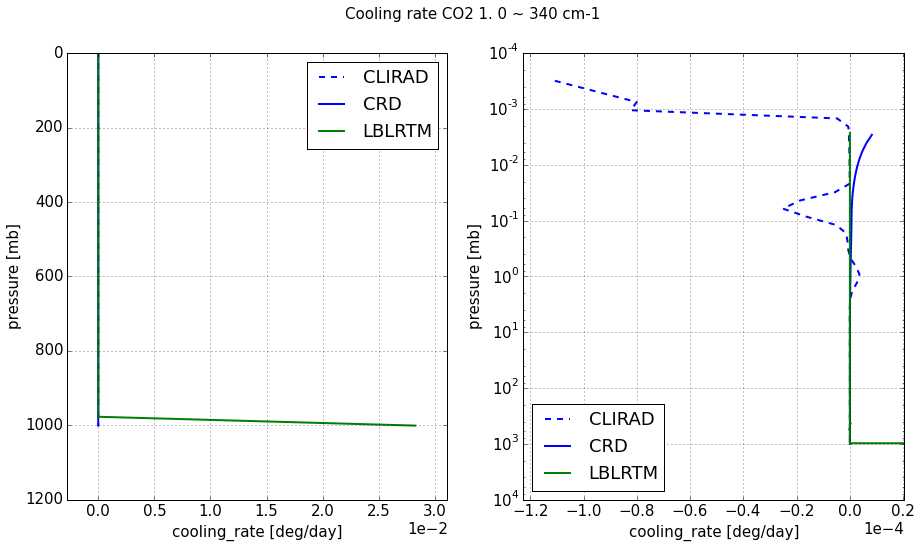


------------------------------------------------------------------------

CLIRAD-LW spectral band 2. 340 ~ 540 cm-1

CLIRAD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -82.31579   0.000003 -82.315787 -1.784270e-06
30   299.800000 -82.31579   0.000005 -82.315785  3.727262e-09
0   1013.000000 -82.31579   0.000008 -82.315782  1.023691e-08

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -82.280681   0.000000 -82.280681      0.000000
30   299.800000 -82.288931   0.007236 -82.281695      0.000028
0   1013.000000 -82.315835   0.169081 -82.146753      0.003434

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -82.293027   0.000000 -82.293027      0.000000
30   299.8000 -82.301149   0.006975 -82.294174      0.000023
0   1013.0000 -82.315849   0.162686 -82.153163      0.007236

CLIRAD - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.035109   0.000003 -0.035106   

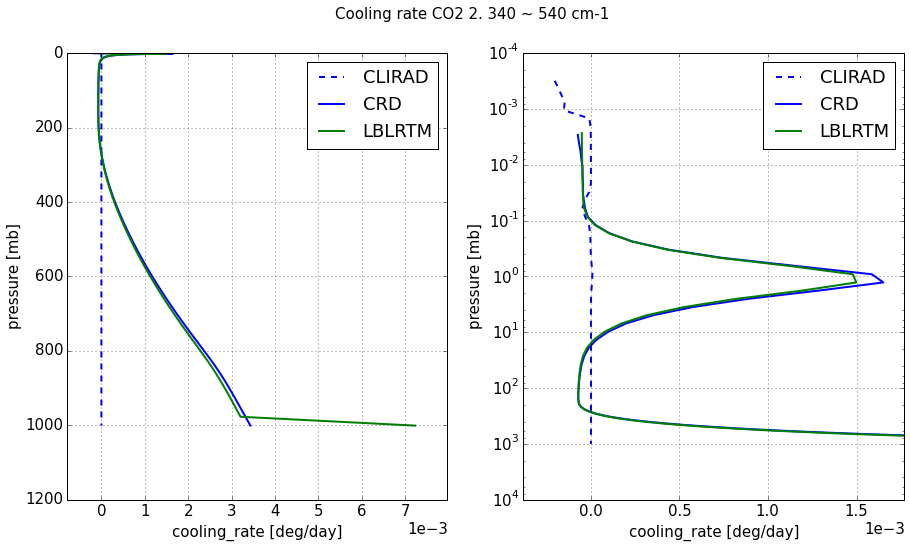


------------------------------------------------------------------------

CLIRAD-LW spectral band 3. 540 ~ 800 cm-1

CLIRAD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -74.98077   0.012381 -74.968389     19.817050
30   299.800000  -80.90141  20.936500 -59.964910      0.156616
0   1013.000000 -112.81600  73.503190 -39.312810      0.356743

CRD
       pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -74.188410   0.000000 -74.188410      0.000000
30   299.800000  -80.423601  21.156397 -59.267205      0.162592
0   1013.000000 -112.837813  74.354289 -38.483524      0.305978

LBLRTM
     pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.0024  -74.362434   0.000000 -74.362434      0.000000
30   299.8000  -80.782419  20.959595 -59.822824      0.153147
0   1013.0000 -112.816764  73.668361 -39.148403      0.310727

CLIRAD - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.792360   0.012381 

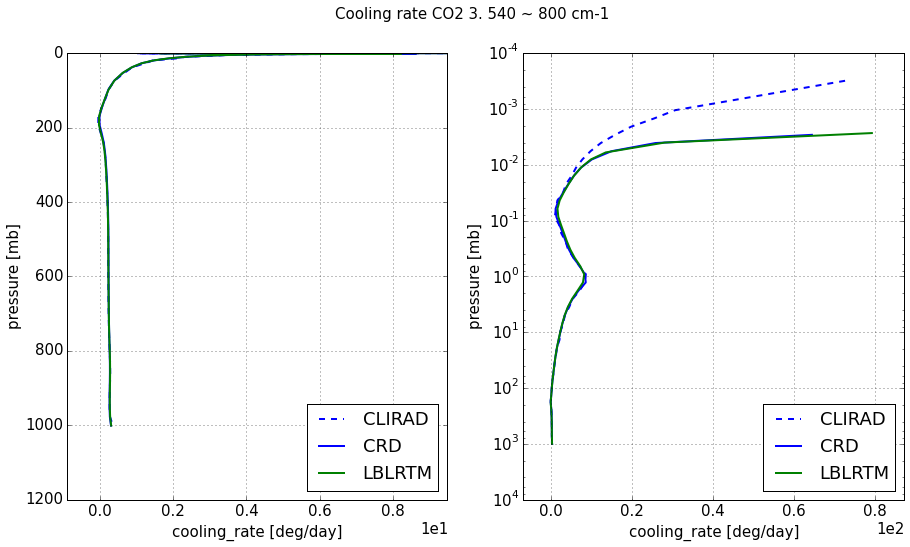


------------------------------------------------------------------------

CLIRAD-LW spectral band 4. 800 ~ 980 cm-1

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -61.28252  4.420017e-08 -61.282520     -0.000446
30   299.800000 -61.32943  2.575173e-02 -61.303678     -0.001012
0   1013.000000 -61.64931  1.214190e+00 -60.435120      0.024057

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -61.310693   0.000000 -61.310693      0.000000
30   299.800000 -61.384263   0.033894 -61.350369     -0.001403
0   1013.000000 -61.681243   1.093502 -60.587741      0.023263

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -61.278278   0.000000 -61.278278      0.000000
30   299.8000 -61.349655   0.031702 -61.317953     -0.001385
0   1013.0000 -61.657526   1.042740 -60.614785      0.013108

CLIRAD - CRD
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0  0.028173  4.42001

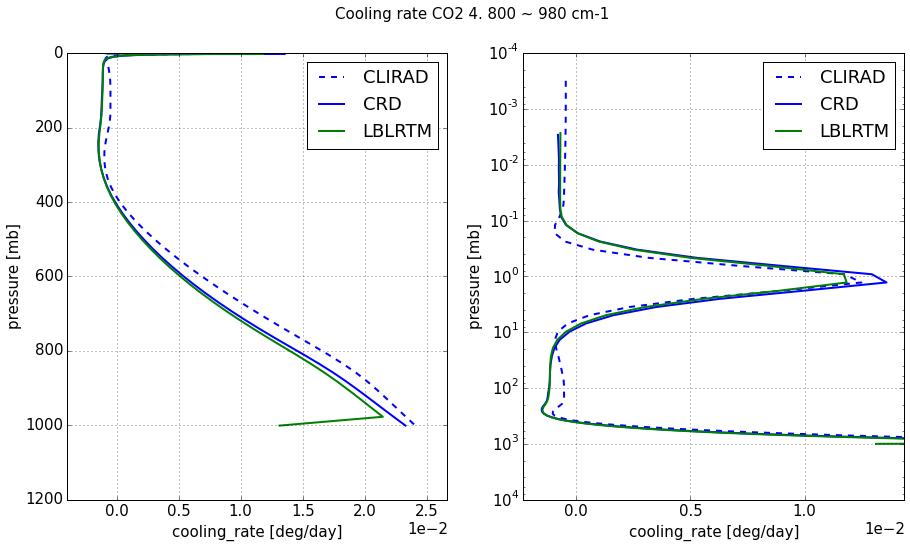


------------------------------------------------------------------------

CLIRAD-LW spectral band 5. 980 ~ 1100 cm-1

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -30.92727  4.965726e-07 -30.927270     -0.000900
30   299.800000 -30.99759  2.873002e-02 -30.968860     -0.001683
0   1013.000000 -31.34389  1.066895e+00 -30.276995      0.020659

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -30.934387   0.000000 -30.934387      0.000000
30   299.800000 -31.011912   0.029204 -30.982708     -0.001911
0   1013.000000 -31.354231   1.071269 -30.282962      0.023063

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.919803   0.000000 -30.919803      0.000000
30   299.8000 -30.996757   0.027965 -30.968792     -0.001897
0   1013.0000 -31.337711   1.028693 -30.309018      0.017637

CLIRAD - CRD
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0  0.007117  4.9657

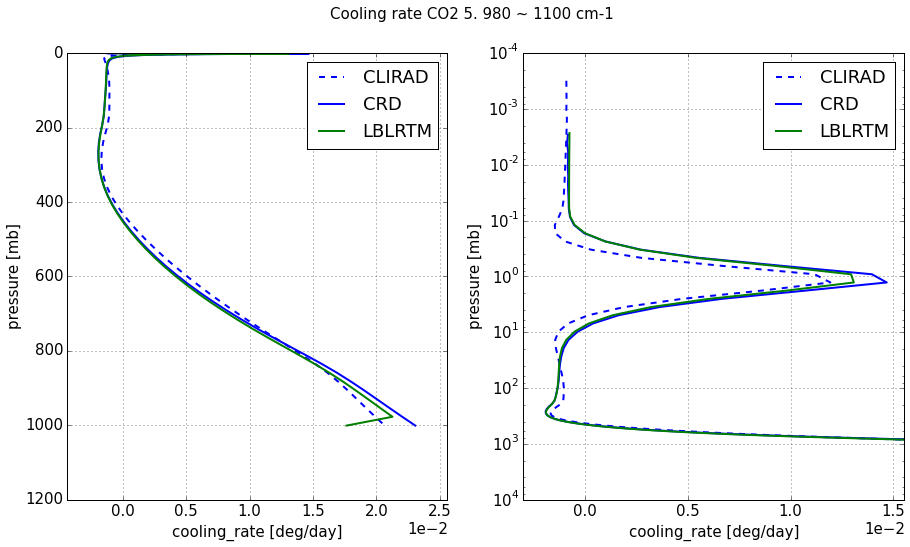


------------------------------------------------------------------------

CLIRAD-LW spectral band 6. 1100 ~ 1215 cm-1

CLIRAD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -23.27341          0 -23.27341            -0
30   299.800000 -23.27341          0 -23.27341            -0
0   1013.000000 -23.27341          0 -23.27341            -0

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -23.269313   0.000000 -23.269313      0.000000
30   299.800000 -23.269348   0.000010 -23.269338     -0.000001
0   1013.000000 -23.269652   0.001256 -23.268396      0.000038

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -23.245248   0.000000 -23.245248      0.000000
30   299.8000 -23.245293   0.000013 -23.245281     -0.000001
0   1013.0000 -23.254791   0.001186 -23.253605     -0.003229

CLIRAD - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.004097   0.000000 -0.004097     

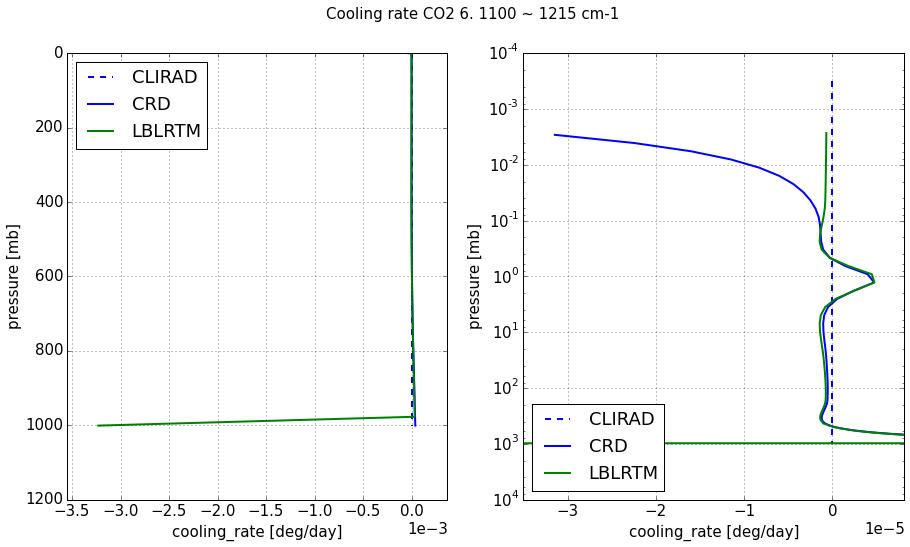


------------------------------------------------------------------------

CLIRAD-LW spectral band 7. 1215 ~ 1380 cm-1

CLIRAD
       pressure  flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -23.7406  2.289835e-16  -23.7406            -0
30   299.800000 -23.7406  1.887379e-15  -23.7406            -0
0   1013.000000 -23.7406  3.608225e-15  -23.7406            -0

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -23.685410   0.000000 -23.685410      0.000000
30   299.800000 -23.719820   0.005797 -23.714023     -0.000668
0   1013.000000 -23.755165   0.067299 -23.687866      0.001106

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -23.659913   0.000000 -23.659913      0.000000
30   299.8000 -23.693705   0.005602 -23.688103     -0.000648
0   1013.0000 -23.736876   0.065068 -23.671808     -0.002148

CLIRAD - CRD
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0 -0.055190  2.289835e-16 

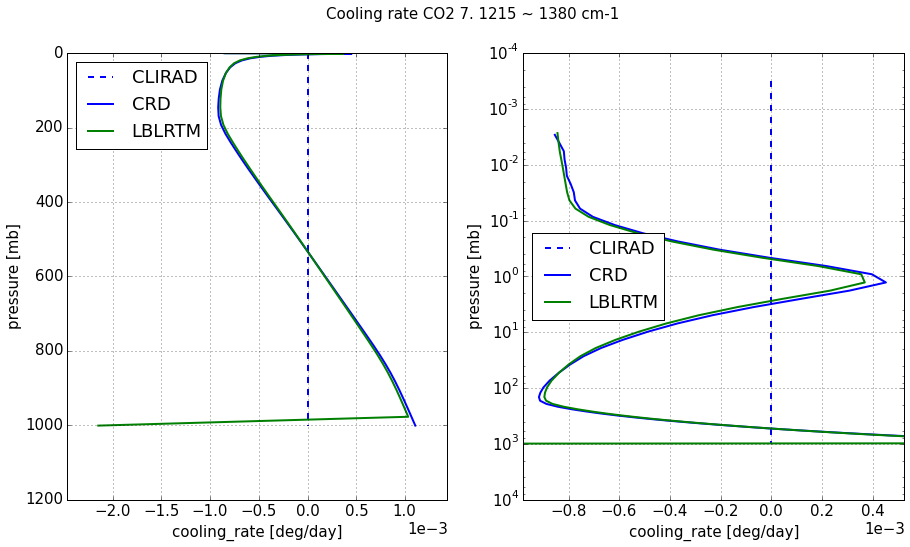


------------------------------------------------------------------------

CLIRAD-LW spectral band 8. 1380 ~ 1900 cm-1

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -30.88056  1.657780e-07 -30.880560 -1.230132e-06
30   299.800000 -30.88056  4.821160e-07 -30.880560 -1.326435e-09
0   1013.000000 -30.88056  3.055093e-06 -30.880557  1.175503e-08

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -30.712876   0.000000 -30.712876      0.000000
30   299.800000 -30.719132   0.000782 -30.718350     -0.000156
0   1013.000000 -30.729595   0.017626 -30.711969      0.000368

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.666144   0.000000 -30.666144      0.000000
30   299.8000 -30.672409   0.000765 -30.671644     -0.000155
0   1013.0000 -30.697533   0.017385 -30.680148     -0.004893

CLIRAD - CRD
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0 -0.167684  1.657

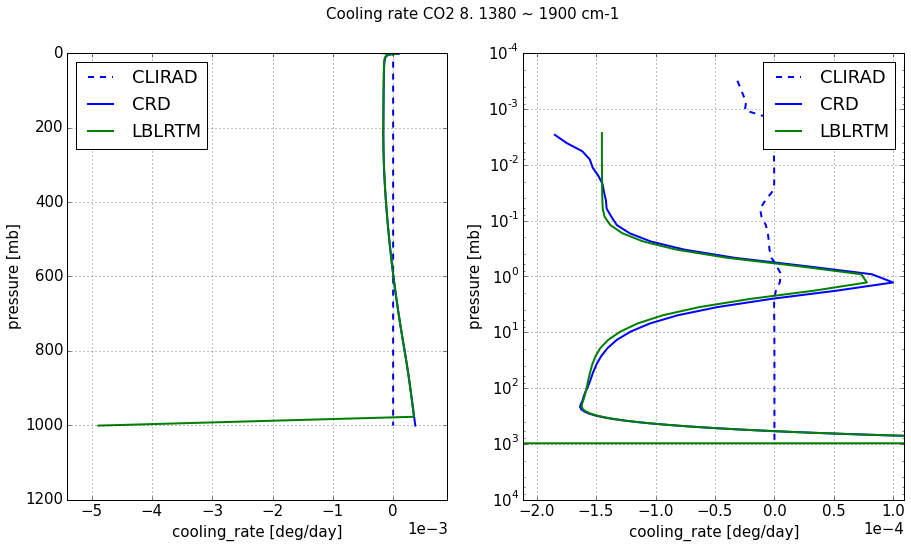


------------------------------------------------------------------------

CLIRAD-LW spectral band 9. 1900 ~ 3000 cm-1

CLIRAD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -6.674498          0 -6.674498            -0
30   299.800000 -6.674498          0 -6.674498            -0
0   1013.000000 -6.674498          0 -6.674498            -0

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -5.798467   0.000000 -5.798467      0.000000
30   299.800000 -5.853937   0.044156 -5.809781     -0.002542
0   1013.000000 -6.625445   0.882282 -5.743164      0.007061

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -5.495534   0.000000 -5.495534      0.000000
30   299.8000 -5.562908   0.055983 -5.506925     -0.002668
0   1013.0000 -6.614782   1.127750 -5.487032     -0.014611

CLIRAD - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.876031   0.000000 -0.876031     -0.000000
30    

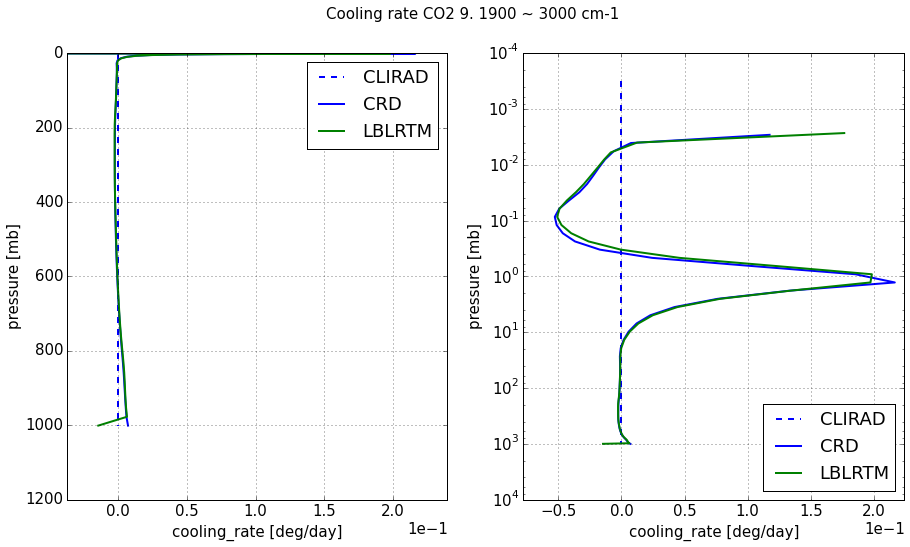


------------------------------------------------------------------------

CLIRAD-LW spectral band 10. 540 ~ 620 cm-1

CLIRAD
       pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.002417       -0          0         0            -0
30   299.800000       -0          0         0            -0
0   1013.000000       -0          0         0            -0

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -29.922537   0.000000 -29.922537       0.00000
30   299.800000 -31.195592   2.531070 -28.664522       0.04107
0   1013.000000 -36.235420  16.135422 -20.099999       0.13053

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.007802   0.000000 -30.007802      0.000000
30   299.8000 -31.291673   2.485550 -28.806123      0.038305
0   1013.0000 -36.231410  15.925742 -20.305668      0.130990

CLIRAD - CRD
    pressure    flux_up  flux_down   net_flux  cooling_rate
70         0  29.922537   0.000000  29.922537      

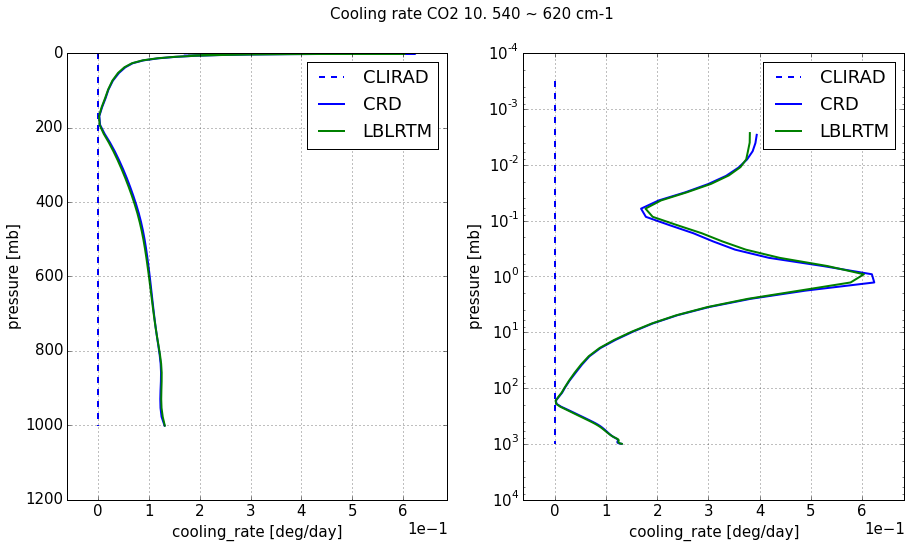


------------------------------------------------------------------------



In [20]:
print('Flux tables and cooling rates in CLIRAD spectral bands')
print()
print()

results_by_cliard_bands(infos_clirad=[('CLIRAD', 'b', '--', pnl_clirad)],
                        infos_lbl=[('CRD', 'b', '-', pnl_crd),
                                   ('LBLRTM', 'g', '-', pnl_lblrtm)],
                        name_molecule=name_molecule)

In [21]:
html_download = ('<a href="./longwave_mls_{name_molecule}'
                 '_by_clirad_bands.xlsx"'
                 'download>longwave_mls_{name_molecule}'
                 '_by_clirad_bands.xlsx</a>')

display.HTML(html_download.format(name_molecule=name_molecule))

In [24]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')